<a href="https://colab.research.google.com/github/dcolinmorgan/test/blob/master/finance_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import datetime as dt
import pandas as pd
import tensorflow as tf
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
f = pdr.DataReader('ticker=RGDPUS', 'econdb')
# from tia.bbg import LocalTerminal
# import tia.analysis.model as model

In [ ]:
today=dt.datetime.today().strftime("%Y-%m-%d")
thirtyya=str(int(str(today).split('-')[0])-30)+'-'+str(today).split('-')[1]+'-'+str(today).split('-')[2]

/usr/local/lib/python3.6/dist-packages/pandas_datareader/base.py:272: SymbolWarning: Failed to read symbol: 'NYMT', replacing with NaN.
  warnings.warn(msg.format(sym), SymbolWarning)


<Figure size 432x288 with 0 Axes>

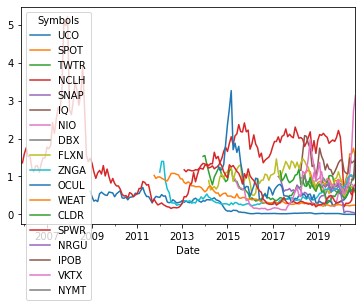

In [ ]:
portfolio = ["UCO","NYMT", "SPOT", "TWTR", "NCLH","SNAP","IQ",'NIO','DBX','FLXN','ZNGA','OCUL','WEAT','CLDR',
           'SPWR','NRGU','IPOB','VKTX']
multpl_stocks = pdr.get_data_yahoo(portfolio,
start = thirtyya,
end = today)
multpl_stock_daily_returns = multpl_stocks['Adj Close'].pct_change()
multpl_stock_monthly_returns = multpl_stocks['Adj Close'].resample('M').ffill().pct_change()
fig = plt.figure()
(multpl_stock_monthly_returns + 1).cumprod().plot()
plt.show()


<Figure size 432x288 with 0 Axes>

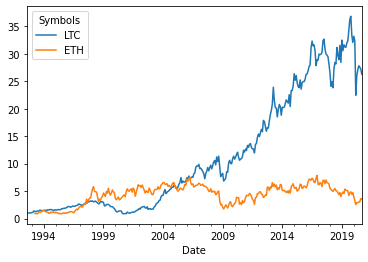

In [ ]:
crypto=['LTC','ETH']
multpl_stocks = pdr.get_data_yahoo(crypto,
start = thirtyya,
end = today)
multpl_stock_daily_returns = multpl_stocks['Adj Close'].pct_change()
multpl_stock_monthly_returns = multpl_stocks['Adj Close'].resample('M').ffill().pct_change()
fig = plt.figure()
(multpl_stock_monthly_returns + 1).cumprod().plot()
plt.show()

<Figure size 432x288 with 0 Axes>

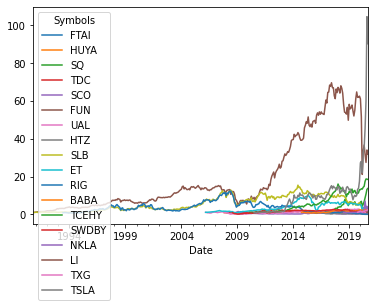

In [ ]:
tickers=['FTAI','HUYA','SQ','TDC','SCO','FUN','UAL','HTZ','SLB','ET','RIG','BABA','TCEHY','SWDBY','NKLA','LI','TXG','TSLA']
multpl_stocks = pdr.get_data_yahoo(tickers,
start = thirtyya,
end = today)
multpl_stock_daily_returns = multpl_stocks['Adj Close'].pct_change()
multpl_stock_monthly_returns = multpl_stocks['Adj Close'].resample('M').ffill().pct_change()
fig = plt.figure()
(multpl_stock_monthly_returns + 1).cumprod().plot()
plt.show()

In [ ]:
multpl_stock_daily_returns

Symbols,FTAI,HUYA,SQ,TDC,SCO,FUN,UAL,HTZ,SLB,ET,RIG,BABA,TCEHY,SWDBY,NKLA,LI,TXG,TSLA
Date,,,,,,,,,,,,,,,,,,
1990-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-02,NaN,NaN,NaN,NaN,NaN,0.021739,NaN,NaN,0.023306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-03,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,0.018633,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-04,NaN,NaN,NaN,NaN,NaN,0.021277,NaN,NaN,-0.012195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-10-05,NaN,NaN,NaN,NaN,NaN,-0.010417,NaN,NaN,0.008231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-24,-0.003187,-0.001989,0.018183,-0.002194,-0.029668,-0.016913,-0.010278,-0.039683,0.000602,-0.007194,0.000000,-0.011797,0.001832,-0.007792,-0.096927,-0.037628,0.009144,0.019534
2020-09-25,0.028133,-0.002790,0.035520,0.011434,0.010791,0.024890,0.044594,0.000000,-0.042118,-0.005435,-0.101124,0.005042,-0.004724,-0.009162,0.018848,0.047051,0.023723,0.050414
2020-09-28,0.027985,-0.008793,0.019275,0.008696,-0.020759,0.023571,0.050877,0.008264,0.033292,0.010929,0.100000,0.018149,0.005053,0.029723,-0.008222,0.017722,0.004345,0.034026


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
# window_size = 64
# batch_size = 256
# train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
# print(train_set)
# print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
  # tf.keras.layers.Lambda(lambda x: x * 5)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
# history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


Epoch 1/100
32/32 [==============================] - 1s 33ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 2/100
32/32 [==============================] - 1s 29ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 3/100
32/32 [==============================] - 1s 28ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 4/100
32/32 [==============================] - 1s 29ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 5/100
32/32 [==============================] - 1s 29ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 6/100
32/32 [==============================] - 1s 28ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 7/100
32/32 [==============================] - 1s 27ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 8/100
32/32 [==============================] - 1s 28ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 9/100
32/32 [==============================] - 1s 27ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 10/100
32/32 [==============================] - 1s 26ms/step - loss: 1.4303e-04 - mae: 0.0115
Epoch 11/

UnboundLocalError: ignored

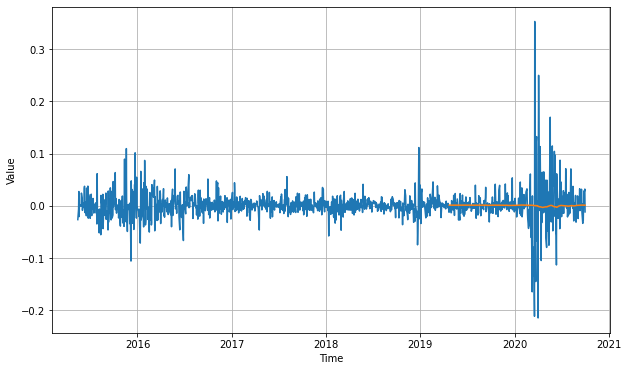

In [ ]:
window_size = 365
batch_size = 20
shuffle_buffer_size = 1000
heat=pd.DataFrame()

for i,AB in enumerate(multpl_stock_daily_returns.columns):  ##per gene
  series=pd.DataFrame(multpl_stock_daily_returns[AB]).dropna()
  # years=np.round(len(series)/365)-1
  # days=int(365*years)
  # split_time=int((round(years*365*.8)-1))
  split_time=int((len(series)-365))

  time_train = series.index[:split_time]
  time_valid = series.index[split_time:]
  series=np.array(series)
  x_train = series[:split_time]
  x_valid = series[split_time:]
  dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

  history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])#,verbose=0)
  
### do prediction and compare to hold out data, or also predict into future/past
  # loss = history.history['loss']
  # epochs = range(len(loss))
  # forecast = []
###need to figure out how to get more prediction out of this by changing dimensions somewhere
  rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
  rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,0] 

###RNN forecasting
  # history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])
  # history = model.fit(dataset, epochs=100,  verbose=0,callbacks=[lr_schedule])
  # for time in range(len(series) - window_size):
  #   forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  # forecast = forecast[split_time-window_size:]
  # results = np.array(forecast)[:, 0, 0]
  # cc=tf.keras.metrics.mean_squared_error(x_valid, results).numpy()

###predicts new time points not held out or trained on  
  # model.predict(series[36:30][np.newaxis])


  cc=tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()
  # if cc<.3:
  plt.figure(figsize=(10, 6))
  jj='MAE for '+str(multpl_stock_daily_returns.index[i])+ ' is '+str(cc)
  # print(jj)
  plot_series(np.append(time_train,time_valid), np.append(x_train,x_valid))
  plot_series(time_valid, rnn_forecast) #results)
    
  # else:
  #   print('MAE for '+str(multpl_stock_daily_returns.index[i])+ ' is '+str(cc))
  Col1=multpl_stock_daily_returns.index[i]
  Col2=cc
  column = [Col1, Col2]
  column=np.transpose(pd.DataFrame((column)))
  # column.to_csv('drive/My Drive/Colab Notebooks dcm/LTCOPD_LSTM_pred40-45.txt',mode='a',header=False,index=False)
  heat=pd.concat([heat,column],axis=0)

In [ ]:
# rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
# rnn_forecast = rnn_forecast[split_time - window_size:-1, -1,0] 
plot_series(np.append(time_train,time_valid), np.append(x_train,x_valid))
plot_series(time_valid, rnn_forecast) #results)
# rnn_forecast#[28*365:]

In [ ]:
time_valid

In [ ]:
plt.clf()
# plt.figure(figsize=(10, 6))
jj='MAE for '+str(multpl_stock_daily_returns.index[i])+ ' is '+str(cc)

# plot_series(np.append(time_train,time_valid), np.append(x_train,x_valid))
# plot_series(time_valid, rnn_forecast) #results)

# zoomed_loss = loss[200:]
# zoomed_epochs = range(200,500)
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast) #results)
# plot_series(np.append(time_train,time_valid), np.append(x_train,x_valid))
# plot_series(time_valid, rnn_forecast) #results)
   


In [ ]:
len(time_valid)#split_time:]

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [ ]:
print(rnn_forecast)